In [2]:
import calcbench as cb
from calcbench.filing import FilingType
import qgrid
from datetime import date
import numpy as np

## Filing Lag
### What is the delay between Calcbench processing the earnings press release and the XBRL 10-K/Q?
### In general companies publish an earnings-press-release, either on a news wire or as an 8-K.  The earnings press release has the face financials and some KPIs.  Calcbench does our best to extract the numbers from the earnings press release.
### A few minutes to ~10 days later the company files and XBRL encoded 10-K/Q with face financials and footnotes.  Calcbench extracts the numbers from the XBRL.

In [15]:
filings = cb.filings_dataframe(
    start_date=date(2022, 10, 12), end_date=date(2022, 11, 12)
)

In [16]:
def filing_timeline(filings):
    filings = filings.sort_values('calcbench_finished_load')
    ten_QK = filings[filings.filing_type == FilingType.annualQuarterlyReport]
    ten_KQ_filing_date = pd.NaT
    if ten_QK.shape[0] > 0:
        ten_KQ_filing_date = ten_QK.iloc[0].calcbench_finished_load
    earnings_press_release = filings[
        filings.filing_type == FilingType.eightk_earningsPressRelease
    ]
    earnings_press_release_filing_date = pd.NaT
    if earnings_press_release.shape[0] > 0:
        earnings_press_release_filing_date = earnings_press_release.iloc[
            0
        ].calcbench_finished_load

    return pd.Series(
        (
            earnings_press_release_filing_date,
            ten_KQ_filing_date,
            ten_KQ_filing_date - earnings_press_release_filing_date,
        ),
        [
            "earnings_press_release_filing_date",
            "10-KQ_filing_date",
            "press_release_to_10_KQ_lag",
        ],
    )

In [22]:
filing_lags = filings.groupby(["ticker", "fiscal_year", "fiscal_period"]).apply(filing_timeline).dropna()

In [24]:
filing_lags

,,,earnings_press_release_filing_date,10-KQ_filing_date,press_release_to_10_KQ_lag
ticker,fiscal_year,fiscal_period,,,
AA,2022,3,2022-10-19 16:22:51,2022-10-27 16:49:40,8 days 00:26:49
AADI,2022,3,2022-11-09 08:03:58,2022-11-09 17:37:01,0 days 09:33:03
AAL,2022,3,2022-10-20 07:01:49,2022-10-20 07:13:15,0 days 00:11:26
AAM,2022,3,2022-11-02 06:59:48,2022-11-08 19:21:56,6 days 12:22:08
AAMC,2022,3,2022-11-02 08:30:10,2022-11-02 08:40:18,0 days 00:10:08
...,...,...,...,...,...
anab,2022,3,2022-11-08 16:09:31,2022-11-08 18:03:42,0 days 01:54:11
ax,2023,1,2022-10-27 16:11:37,2022-10-28 06:26:33,0 days 14:14:56
fnd,2022,3,2022-11-03 16:09:00,2022-11-03 19:21:14,0 days 03:12:14


### Most of the 10-K/Qs a received on the same day

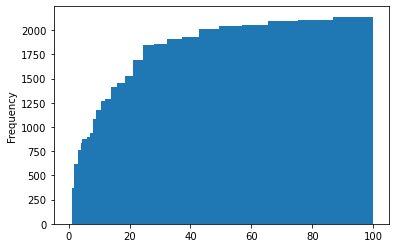

In [26]:
filing_lags.press_release_to_10_KQ_lag.astype("timedelta64[h]").plot.hist(
    cumulative=True, bins=np.logspace(-1, 2, 50)
)

In [ ]:
filing_lags.press_release_to_10_KQ_lag.describe()

## Filing Data
### What data are we getting from earnings press-releases vs XBRL 10-K/Qs?

In [27]:
company_idenfiers = ['PEP']

In [28]:
data = cb.standardized(company_identifiers=company_idenfiers, point_in_time=True)

In [29]:
pep_data = data.merge(
    filings[["fiscal_year", "fiscal_period"]].rename(
        columns={
            "fiscal_year": "filing_fiscal_year",
            "fiscal_period": "filing_fiscal_period",
        }
    ),
    left_on="filing_id",
    right_index=True,
)

In [32]:
pep_data

value  \
ticker metric                                             fiscal_period date_reported                       
PEP    AOCIDerivativeReclassificationDesignatedCommodi... 2022-3        2022-10-12 06:14:34  5.100000e+07   
       AccumulatedDepreciation                            2022-3        2022-10-12 06:14:34  2.530000e+10   
       AccumulatedDepreciationDepletionAndAmortization... 2022-3        2022-10-12 06:14:34  2.530000e+10   
       AccumulatedOtherComprehensiveIncomeLossDefinedB... 2022-3        2022-10-12 06:14:34  2.879000e+09   
       AccumulatedOtherComprehensiveIncomeLossForeignC... 2022-3        2022-10-12 06:14:34 -1.191900e+10   
       AccumulatedOtherComprehensiveIncomeLossNetOfTax    2022-3        2022-10-12 06:14:34 -1.474300e+10   
       AllocatedShareBasedCompensationExpense             2022-3        2022-10-12 06:14:34  7.700000e+07   
       AllowanceForDoubtfulAccountsReceivable             2022-3        2022-10-12 06:14:34  1.650000e+08   
       AvailableForSaleSecuritiesDebtSecurities           2022-3        2022-10-12 06:14:34  5.550000e+08   
       AvgSharesOutstandingBasic                          2022-3        2022-10-12 06:14:34  1.380000e+09   
       CAPEX                                              2022-3        2022-10-12 06:14:34  1.051000e+09   
       CAPEXgross                                         2022-3        2022-10-12 06:14:34  1.057000e+09   
       CapitalAssetSales                                  2022-3        2022-10-12 06:14:34  6.000000e+06   
       CashIncrease                                       2022-3        2022-10-12 06:14:34  9.730000e+08   
       CommercialPaper                                    2022-3        2022-10-12 06:14:34  0.000000e+00   
       ComprehensiveIncomeNetOfTax                        2022-3        2022-10-12 06:14:34  2.375000e+09   
       DefinedBenefitPlanAmortizationOfGainsLoss          2022-3        2022-10-12 06:14:34 -4.000000e+07   
       DefinedBenefitPlanAmortizationOfPriorServiceCos... 2022-3        2022-10-12 06:14:34 -9.000000e+06   
       DefinedBenefitPlanBusinessCombinationsAndAcquis... 2022-3        2022-10-12 06:14:34  0.000000e+00   
       DefinedBenefitPlanContributionsByEmployer          2022-3        2022-10-12 06:14:34  7.500000e+07   
       DefinedBenefitPlanExpectedReturnOnPlanAssets       2022-3        2022-10-12 06:14:34  2.650000e+08   
       DefinedBenefitPlanInterestCost                     2022-3        2022-10-12 06:14:34  1.390000e+08   
       DefinedBenefitPlanNetPeriodicBenefitCost           2022-3        2022-10-12 06:14:34  9.600000e+07   
       DefinedBenefitPlanRecognizedNetGainLossDueToSet... 2022-3        2022-10-12 06:14:34 -5.900000e+07   
       DefinedBenefitPlanServiceCost                      2022-3        2022-10-12 06:14:34  1.320000e+08   
       DepreciationAmortization                           2022-3        2022-10-12 06:14:34  7.820000e+08   
       DerivativeFairValueOfDerivativeAsset               2022-3        2022-10-12 06:14:34  1.290000e+08   
       DerivativeFairValueOfDerivativeLiability           2022-3        2022-10-12 06:14:34  1.044000e+09   
       DerivativeNotionalAmount                           2022-3        2022-10-12 06:14:34  9.500000e+09   
       EBITDA                                             2022-3        2022-10-12 06:14:34  4.171000e+09   
       EPSBasic                                           2022-3        2022-10-12 06:14:34  1.960000e+00   
       EPSDiluted                                         2022-3        2022-10-12 06:14:34  1.950000e+00   
       EffectOfExchangeRateOnCash                         2022-3        2022-10-12 06:14:34 -1.140000e+08   
       EntityCommonStockSharesOutstanding                 2022-3        2022-10-12 06:14:34  1.377709e+09   
       EquityMethodInvestmentOwnershipPercentage          2022-3        2022-10-12 06:14:34  3.900000e-01   
       EquityMethodInvestments                            2021-0   

### For PEP Calcbench extracted 51 values from the 8-K and 94 from the 10-Q.
#### Number from both the 8-K and 10-Q are only included in the 8-K count.

In [30]:
pep_data['filing_type'].value_counts()

10-Q    94
8-K     51
Name: filing_type, dtype: int64